# Data manipulation in Julia

In this session, we will cover the basics of data manipulation in Julia, including
- reading
- merging/joining
- summarizing/grouping
- plotting

At the end of the class, you should be able to construct these plots:

<table>
<tr>
<td> <img src="figures/n_loglik_val_A.pdf" style="width: 350px;"/></td>
<td> <img src="figures/n_loglik_val_F.pdf" style="width: 350px;"/></td>
</tr></table>

We study the sparse inverse covariance problem and compare 3 methods: 
- Meinshausena and Buhlmann's approximation (BM)
- Graphical Lasso (Glasso)
- Discrete formulation (Big-M)

We design experiments with 
- fixed dimension $p=200$
- fixed underlying true sparsity $k_{true}=199$
- varying number of samples $n$ (12 different values)

We run each experiment $10$ times and want to report average results over all simulations. 

## Step 1: Read the data

We generate one CSV file per method (3) per experiment (12) and per simulation (10) !

Let us look at the first CSV file

In [1]:
using DataFrames, CSV

In [2]:
?CSV.read

`CSV.read(fullpath::Union{AbstractString,IO}, sink=DataFrame; kwargs...)` => `typeof(sink)`

Parses a delimited file into a Julia structure (a DataFrame by default, but any valid Tables.jl sink function can be provided).

Minimal error-reporting happens w/ `CSV.read` for performance reasons; for problematic csv files, try [`CSV.validate`](@ref) which takes exact same arguments as `CSV.read` and provides much more information for why reading the file failed.

Positional arguments:

  * `fullpath`: can be a file name (String) of the location of the csv file or `IO` object to read the csv from directly
  * `sink`: `DataFrame` by default, but may also be any other Tables.jl sink function

Supported keyword arguments include:

  * File layout options:

      * `header=1`: the `header` argument can be an `Int`, indicating the row to parse for column names; or a `Range`, indicating a span of rows to be combined together as column names; or an entire `Vector of Symbols` or `Strings` to use as column names
      * `normalizenames=false`: whether column names should be "normalized" into valid Julia identifier symbols
      * `datarow`: an `Int` argument to specify the row where the data starts in the csv file; by default, the next row after the `header` row is used
      * `skipto::Int`: similar to `datarow`, specifies the number of rows to skip before starting to read data
      * `footerskip::Int`: number of rows at the end of a file to skip parsing
      * `limit`: an `Int` to indicate a limited number of rows to parse in a csv file
      * `transpose::Bool`: read a csv file "transposed", i.e. each column is parsed as a row
      * `comment`: a `String` that occurs at the beginning of a line to signal parsing that row should be skipped
      * `use_mmap::Bool=!Sys.iswindows()`: whether the file should be mmapped for reading, which in some cases can be faster
  * Parsing options:
  * `missingstrings`, `missingstring`: either a `String`, or `Vector{String}` to use as sentinel values that will be parsed as `missing`; by default, only an empty field (two consecutive delimiters) is considered `missing`

      * `delim=','`: a `Char` or `String` that indicates how columns are delimited in a file
      * `ignorerepeated::Bool=false`: whether repeated (consecutive) delimiters should be ignored while parsing; useful for fixed-width files with delimiter padding between cells
      * `quotechar='"'`, `openquotechar`, `closequotechar`: a `Char` (or different start and end characters) that indicate a quoted field which may contain textual delimiters or newline characters
      * `escapechar='\'`: the `Char` used to escape quote characters in a text field
      * `dateformat::Union{String, Dates.DateFormat, Nothing}`: a date format string to indicate how Date/DateTime columns are formatted in a delimited file
      * `decimal`: a `Char` indicating how decimals are separated in floats, i.e. `3.14` used '.', or `3,14` uses a comma ','
      * `truestrings`, `falsestrings`: `Vectors of Strings` that indicate how `true` or `false` values are represented
  * Column Type Options:

      * `types`: a Vector or Dict of types to be used for column types; a Dict can map column index `Int`, or name `Symbol` or `String` to type for a column, i.e. Dict(1=>Float64) will set the first column as a Float64, Dict(:column1=>Float64) will set the column named column1 to Float64 and, Dict("column1"=>Float64) will set the column1 to Float64
      * `typemap::Dict{Type, Type}`: a mapping of a type that should be replaced in every instance with another type, i.e. `Dict(Float64=>String)` would change every detected `Float64` column to be parsed as `Strings`
      * `allowmissing=:all`: indicate how missing values are allowed in columns; possible values are `:all` - all columns may contain missings, `:auto` - auto-detect columns that contain missings or, `:none` - no columns may contain missings
      * `categorical::Union{Bool, Real}=false`: if `true`, columns detected as `String` are returned as a `CategoricalArray`; alternatively, the proportion of unique values below which `String` columns should be treated as categorical (for example 0.1 for 10%)
      * `strict::Bool=false`: whether invalid values should throw a parsing error or be replaced with missing values


In [3]:
df = CSV.read("experiment/baseline_BM_0.csv")

,run,p,n,ktrue,lambda,k,time,objval,EBIC,loglik_val,loglik_test,TF,FF,operatorNorm,frobeniusNorm,L1MatrixNorm,LInfVectorNorm
,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Float64⍰,Int64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,0,200,50,199,0.650391,50,0.339093,300.028,233.752,231.957,228.719,296.0,4.0,2.49816,16.4842,3.93596,0.935962
2,0,200,50,199,0.541016,100,0.353749,285.591,238.208,221.608,218.917,384.0,16.0,2.37917,15.749,3.83156,0.892957
3,0,200,50,199,0.460938,149,0.358401,273.489,242.102,211.237,208.907,456.0,42.0,2.25852,14.9471,3.72804,0.857387
4,0,200,50,199,0.422852,199,0.55993,267.044,250.186,205.402,203.288,490.0,106.0,2.18994,14.4682,3.65937,0.839065
5,0,200,50,199,0.385742,249,0.547767,260.111,257.355,199.16,197.26,512.0,184.0,2.1109,13.933,3.57429,0.820244
6,0,200,50,199,0.36499,298,0.802488,255.907,266.587,195.478,193.785,526.0,266.0,2.058,13.5981,3.51101,0.809273
7,0,200,50,199,0.347534,348,0.840247,252.135,276.116,192.289,190.692,536.0,352.0,2.0072,13.296,3.45975,0.799783
8,0,200,50,199,0.329712,398,0.855924,248.049,285.062,188.999,187.452,542.0,442.0,1.92268,12.9505,3.32232,0.789837


In [4]:
size(df)

(8, 17)

Let us have a look at the columns

In [5]:
names(df)

17-element Array{Symbol,1}:
 :run           
 :p             
 :n             
 :ktrue         
 :lambda        
 :k             
 :time          
 :objval        
 :EBIC          
 :loglik_val    
 :loglik_test   
 :TF            
 :FF            
 :operatorNorm  
 :frobeniusNorm 
 :L1MatrixNorm  
 :LInfVectorNorm

The first 4 columns identify the experiment and the simulation
 - :run is the number of the simulation (between 0 and 9)          
 - :p is the dimension of the problem             
 - :n is the number of samples            
 - :ktrue is the true sparsity pattern 

They take the same value for all rows in the file.

The other columns correspond to the regularization path:
 - :lambda is the value of the regularization paramter       
 - :k is the sparsity of the corresponding estimator      
 - :time is the time needed to compute the solution       
 - :objval is the in-sample objective value

Then, we report performance metrics that can be used for cross-validation:
 - :EBIC is the value of the in-sample Extended Bayesian Information Criterion (the lower the better)
 - :loglik_val is the value of the negative log-likelihood on the validation set (the lower the better)

Finally, we report final metrics on the test set
 - :loglik_test is the negative log-likelihood on the test test
 - :TF is the number of true features selected          
 - :FF is the number of false features selected          

We will not use the final 4 columns

**Side note:** Renaming columns

In [6]:
DataFrames.rename(df, (:operatorNorm => :uselessColumn))

,run,p,n,ktrue,lambda,k,time,objval,EBIC,loglik_val,loglik_test,TF,FF,uselessColumn,frobeniusNorm,L1MatrixNorm,LInfVectorNorm
,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Float64⍰,Int64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,0,200,50,199,0.650391,50,0.339093,300.028,233.752,231.957,228.719,296.0,4.0,2.49816,16.4842,3.93596,0.935962
2,0,200,50,199,0.541016,100,0.353749,285.591,238.208,221.608,218.917,384.0,16.0,2.37917,15.749,3.83156,0.892957
3,0,200,50,199,0.460938,149,0.358401,273.489,242.102,211.237,208.907,456.0,42.0,2.25852,14.9471,3.72804,0.857387
4,0,200,50,199,0.422852,199,0.55993,267.044,250.186,205.402,203.288,490.0,106.0,2.18994,14.4682,3.65937,0.839065
5,0,200,50,199,0.385742,249,0.547767,260.111,257.355,199.16,197.26,512.0,184.0,2.1109,13.933,3.57429,0.820244
6,0,200,50,199,0.36499,298,0.802488,255.907,266.587,195.478,193.785,526.0,266.0,2.058,13.5981,3.51101,0.809273
7,0,200,50,199,0.347534,348,0.840247,252.135,276.116,192.289,190.692,536.0,352.0,2.0072,13.296,3.45975,0.799783
8,0,200,50,199,0.329712,398,0.855924,248.049,285.062,188.999,187.452,542.0,442.0,1.92268,12.9505,3.32232,0.789837


But did not change the original table df

In [7]:
df

,run,p,n,ktrue,lambda,k,time,objval,EBIC,loglik_val,loglik_test,TF,FF,operatorNorm,frobeniusNorm,L1MatrixNorm,LInfVectorNorm
,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Float64⍰,Int64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,0,200,50,199,0.650391,50,0.339093,300.028,233.752,231.957,228.719,296.0,4.0,2.49816,16.4842,3.93596,0.935962
2,0,200,50,199,0.541016,100,0.353749,285.591,238.208,221.608,218.917,384.0,16.0,2.37917,15.749,3.83156,0.892957
3,0,200,50,199,0.460938,149,0.358401,273.489,242.102,211.237,208.907,456.0,42.0,2.25852,14.9471,3.72804,0.857387
4,0,200,50,199,0.422852,199,0.55993,267.044,250.186,205.402,203.288,490.0,106.0,2.18994,14.4682,3.65937,0.839065
5,0,200,50,199,0.385742,249,0.547767,260.111,257.355,199.16,197.26,512.0,184.0,2.1109,13.933,3.57429,0.820244
6,0,200,50,199,0.36499,298,0.802488,255.907,266.587,195.478,193.785,526.0,266.0,2.058,13.5981,3.51101,0.809273
7,0,200,50,199,0.347534,348,0.840247,252.135,276.116,192.289,190.692,536.0,352.0,2.0072,13.296,3.45975,0.799783
8,0,200,50,199,0.329712,398,0.855924,248.049,285.062,188.999,187.452,542.0,442.0,1.92268,12.9505,3.32232,0.789837


Suffix "!" denotes functions which modify their argument (convention only)

In [8]:
DataFrames.rename!(df, (:operatorNorm => :uselessColumn))
df

,run,p,n,ktrue,lambda,k,time,objval,EBIC,loglik_val,loglik_test,TF,FF,uselessColumn,frobeniusNorm,L1MatrixNorm,LInfVectorNorm
,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Float64⍰,Int64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,0,200,50,199,0.650391,50,0.339093,300.028,233.752,231.957,228.719,296.0,4.0,2.49816,16.4842,3.93596,0.935962
2,0,200,50,199,0.541016,100,0.353749,285.591,238.208,221.608,218.917,384.0,16.0,2.37917,15.749,3.83156,0.892957
3,0,200,50,199,0.460938,149,0.358401,273.489,242.102,211.237,208.907,456.0,42.0,2.25852,14.9471,3.72804,0.857387
4,0,200,50,199,0.422852,199,0.55993,267.044,250.186,205.402,203.288,490.0,106.0,2.18994,14.4682,3.65937,0.839065
5,0,200,50,199,0.385742,249,0.547767,260.111,257.355,199.16,197.26,512.0,184.0,2.1109,13.933,3.57429,0.820244
6,0,200,50,199,0.36499,298,0.802488,255.907,266.587,195.478,193.785,526.0,266.0,2.058,13.5981,3.51101,0.809273
7,0,200,50,199,0.347534,348,0.840247,252.135,276.116,192.289,190.692,536.0,352.0,2.0072,13.296,3.45975,0.799783
8,0,200,50,199,0.329712,398,0.855924,248.049,285.062,188.999,187.452,542.0,442.0,1.92268,12.9505,3.32232,0.789837


>**\[Exercise\]**: Read/Concatenate 

> There are 120 files for the method "BM", write a Julia function which reads and concatenates all the CSV files into one dataframe

> Note: you can concatenate dataframes horizontally (preserves the first dimension) or vertically (preserves the second dimension) using hcat(df1, df2) or vcat(df1, df2) respectively

In [9]:
function merge_files(prefix)
  filename = string(prefix, 0, ".csv")
  df = CSV.read(filename)
  for file in 1:119
    filename = string(prefix, file, ".csv")
    data = CSV.read(filename)
    df = vcat(df, data)
  end
  return df
end

merge_files (generic function with 1 method)

In [10]:
bm = merge_files("experiment/baseline_BM_")

,run,p,n,ktrue,lambda,k,time,objval,EBIC,loglik_val,loglik_test,TF,FF,operatorNorm,frobeniusNorm,L1MatrixNorm,LInfVectorNorm
,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Float64⍰,Int64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,0,200,50,199,0.650391,50,0.339093,300.028,233.752,231.957,228.719,296.0,4.0,2.49816,16.4842,3.93596,0.935962
2,0,200,50,199,0.541016,100,0.353749,285.591,238.208,221.608,218.917,384.0,16.0,2.37917,15.749,3.83156,0.892957
3,0,200,50,199,0.460938,149,0.358401,273.489,242.102,211.237,208.907,456.0,42.0,2.25852,14.9471,3.72804,0.857387
4,0,200,50,199,0.422852,199,0.55993,267.044,250.186,205.402,203.288,490.0,106.0,2.18994,14.4682,3.65937,0.839065
5,0,200,50,199,0.385742,249,0.547767,260.111,257.355,199.16,197.26,512.0,184.0,2.1109,13.933,3.57429,0.820244
6,0,200,50,199,0.36499,298,0.802488,255.907,266.587,195.478,193.785,526.0,266.0,2.058,13.5981,3.51101,0.809273
7,0,200,50,199,0.347534,348,0.840247,252.135,276.116,192.289,190.692,536.0,352.0,2.0072,13.296,3.45975,0.799783
8,0,200,50,199,0.329712,398,0.855924,248.049,285.062,188.999,187.452,542.0,442.0,1.92268,12.9505,3.32232,0.789837
9,1,200,50,199,0.585938,50,0.382404,291.702,228.96,219.76,220.356,292.0,8.0,2.40384,16.4579,3.92658,0.939546


## Step 2: Define relevant columns

In the end, we want to represent accuracy ($A$) and false detection rate ($F$) as a funtion of $n/p$

>**\[Exercise\]**: Add columns

> Write a Julia function which takes a dataframe and add three columns: n/p, A and F.

> Note:
$$ A = \dfrac{TF - p}{2 k_{true}}, \quad F = \dfrac{FF}{2 k} $$

In [11]:
function add_columns!(df)
    df[:ntop] = df[:n] ./ df[:p]
    df[:A] = (df[:TF] .- df[:p]) ./ 2 ./ df[:ktrue]
    df[:F] = df[:FF] ./ 2 ./ df[:k]
end

add_columns! (generic function with 1 method)

In [12]:
add_columns!(bm)
bm

,run,p,n,ktrue,lambda,k,time,objval,EBIC,loglik_val,loglik_test,TF,FF,operatorNorm,frobeniusNorm,L1MatrixNorm,LInfVectorNorm,ntop,A,F
,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Float64⍰,Int64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64,Float64,Float64
1,0,200,50,199,0.650391,50,0.339093,300.028,233.752,231.957,228.719,296.0,4.0,2.49816,16.4842,3.93596,0.935962,0.25,0.241206,0.04
2,0,200,50,199,0.541016,100,0.353749,285.591,238.208,221.608,218.917,384.0,16.0,2.37917,15.749,3.83156,0.892957,0.25,0.462312,0.08
3,0,200,50,199,0.460938,149,0.358401,273.489,242.102,211.237,208.907,456.0,42.0,2.25852,14.9471,3.72804,0.857387,0.25,0.643216,0.14094
4,0,200,50,199,0.422852,199,0.55993,267.044,250.186,205.402,203.288,490.0,106.0,2.18994,14.4682,3.65937,0.839065,0.25,0.728643,0.266332
5,0,200,50,199,0.385742,249,0.547767,260.111,257.355,199.16,197.26,512.0,184.0,2.1109,13.933,3.57429,0.820244,0.25,0.78392,0.369478
6,0,200,50,199,0.36499,298,0.802488,255.907,266.587,195.478,193.785,526.0,266.0,2.058,13.5981,3.51101,0.809273,0.25,0.819095,0.446309
7,0,200,50,199,0.347534,348,0.840247,252.135,276.116,192.289,190.692,536.0,352.0,2.0072,13.296,3.45975,0.799783,0.25,0.844221,0.505747
8,0,200,50,199,0.329712,398,0.855924,248.049,285.062,188.999,187.452,542.0,442.0,1.92268,12.9505,3.32232,0.789837,0.25,0.859296,0.555276
9,1,200,50,199,0.585938,50,0.382404,291.702,228.96,219.76,220.356,292.0,8.0,2.40384,16.4579,3.92658,0.939546,0.25,0.231156,0.08


## Step 3: Perform the CV

For each experiment and simulation, we need to select the regularization parameter which minimizes the cross-validation criterion (either :EBIC or :loglik_val)

We need to use a "group by" strategy

In [13]:
?DataFrames.groupby

A view of an AbstractDataFrame split into row groups

```julia
groupby(d::AbstractDataFrame, cols; sort = false, skipmissing = false)
groupby(cols; sort = false, skipmissing = false)
```

### Arguments

  * `d` : an AbstractDataFrame to split (optional, see [Returns](#returns))
  * `cols` : data table columns to group by
  * `sort`: whether to sort rows according to the values of the grouping columns `cols`
  * `skipmissing`: whether to skip rows with `missing` values in one of the grouping columns `cols`

### Returns

A `GroupedDataFrame` : a grouped view into `d`

### Details

An iterator over a `GroupedDataFrame` returns a `SubDataFrame` view for each grouping into `d`. A `GroupedDataFrame` also supports indexing by groups, `map` (which applies a function to each group) and `combine` (which applies a function to each group and combines the result into a data frame).

See the following for additional split-apply-combine operations:

  * `by` : split-apply-combine using functions
  * `aggregate` : split-apply-combine; applies functions in the form of a cross product
  * `colwise` : apply a function to each column in an `AbstractDataFrame` or `GroupedDataFrame`
  * `map` : apply a function to each group of a `GroupedDataFrame` (without combining)
  * `combine` : combine a `GroupedDataFrame`, optionally applying a function to each group

### Examples

```julia
df = DataFrame(a = repeat([1, 2, 3, 4], outer=[2]),
               b = repeat([2, 1], outer=[4]),
               c = randn(8))
gd = groupby(df, :a)
gd[1]
last(gd)
vcat([g[:b] for g in gd]...)
for g in gd
    println(g)
end
```


The command

In [14]:
gr = DataFrames.groupby(bm, [:run, :p, :n, :ktrue])

GroupedDataFrame{DataFrame} with 120 groups based on keys: :run, :p, :n, :ktrue
First Group: 8 rows. Omitted printing of 13 columns
│ Row │ run    │ p      │ n      │ ktrue  │ lambda   │ k      │ time     │
│     │ Int64⍰ │ Int64⍰ │ Int64⍰ │ Int64⍰ │ Float64⍰ │ Int64⍰ │ Float64⍰ │
├─────┼────────┼────────┼────────┼────────┼──────────┼────────┼──────────┤
│ 1   │ 0      │ 200    │ 50     │ 199    │ 0.650391 │ 50     │ 0.339093 │
│ 2   │ 0      │ 200    │ 50     │ 199    │ 0.541016 │ 100    │ 0.353749 │
│ 3   │ 0      │ 200    │ 50     │ 199    │ 0.460938 │ 149    │ 0.358401 │
│ 4   │ 0      │ 200    │ 50     │ 199    │ 0.422852 │ 199    │ 0.55993  │
│ 5   │ 0      │ 200    │ 50     │ 199    │ 0.385742 │ 249    │ 0.547767 │
│ 6   │ 0      │ 200    │ 50     │ 199    │ 0.36499  │ 298    │ 0.802488 │
│ 7   │ 0      │ 200    │ 50     │ 199    │ 0.347534 │ 348    │ 0.840247 │
│ 8   │ 0      │ 200    │ 50     │ 199    │ 0.329712 │ 398    │ 0.855924 │
⋮
Last Group: 8 rows. Omitted printing of 1

creates a "list of dataframes", corresponding to each group.

In [15]:
length(gr)

120

You can iterate over it

In [16]:
for subgroup in gr
    println(size(subgroup))
end

(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)
(8, 20)


>**\[Exercise\]**: Group by/Concatenate 

> Write a Julia function which takes as arguments
- a dataframe, 
- the list of columns which define an experiment, 
- the column of the cross-validation criterion 

> and performs the cross validation for all experiments.

In [17]:
function perform_cv(df, id_cols, crit_col)
    df_cv = DataFrames.similar(df, 0) #Creates an empty dataframe with the same columns as df
    for g in DataFrames.groupby(df, id_cols)
        i = argmin(g[:,crit_col])
        df_cv = vcat(df_cv, g[i:i,:])
    end 
    return df_cv
end    

perform_cv (generic function with 1 method)

In [18]:
bm_cv = perform_cv(bm, [:run, :p, :n, :ktrue], :loglik_val)

,run,p,n,ktrue,lambda,k,time,objval,EBIC,loglik_val,loglik_test,TF,FF,operatorNorm,frobeniusNorm,L1MatrixNorm,LInfVectorNorm,ntop,A,F
,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Float64⍰,Int64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64,Float64,Float64
1,0,200,50,199,0.329712,398,0.855924,248.049,285.062,188.999,187.452,542.0,442.0,1.92268,12.9505,3.32232,0.789837,0.25,0.859296,0.555276
2,1,200,50,199,0.322754,398,0.768193,248.346,291.158,192.837,192.678,502.0,486.0,2.01886,13.7237,3.25304,0.814089,0.25,0.758794,0.610553
3,2,200,50,199,0.324585,398,0.828302,248.1,290.85,190.976,194.458,450.0,540.0,2.37468,15.6172,3.81919,0.964486,0.25,0.628141,0.678392
4,3,200,50,199,0.325928,398,0.805412,250.671,296.294,192.076,197.15,472.0,514.0,2.21681,14.8485,3.23965,0.888515,0.25,0.683417,0.645729
5,4,200,50,199,0.333435,398,0.898663,250.827,293.488,197.08,198.294,480.0,508.0,2.16701,14.3836,3.35009,0.857089,0.25,0.703518,0.638191
6,5,200,50,199,0.324219,398,0.642827,249.395,293.639,191.021,194.283,450.0,530.0,2.36704,16.3023,3.31572,1.01366,0.25,0.628141,0.665829
7,6,200,50,199,0.332031,398,0.655028,250.715,292.597,198.384,195.36,484.0,500.0,2.12327,14.7572,3.16053,0.892829,0.25,0.713568,0.628141
8,7,200,50,199,0.322754,398,0.86623,247.3,287.449,185.347,193.086,498.0,484.0,2.09576,13.3006,3.10362,0.787046,0.25,0.748744,0.60804
9,8,200,50,199,0.329712,398,0.818161,250.767,294.601,201.358,196.739,470.0,520.0,2.22388,15.3729,3.46907,0.939926,0.25,0.678392,0.653266


In [19]:
size(bm_cv)

(120, 20)

## Step 4: Aggregate results

For each experiment, we want to compute average accuracy and false detection (and their corresponding standard deviation)

>**\[Exercise\]**: Group by/Concatenate 

> Use a "group by" syntax to write a Julia function which takes as arguments
- a dataframe, 
- the list of columns which define an experiment, 

> and returns a dataframe with average/standard deviation for A.

In [20]:
using Statistics
function aggregate_A(df, exp_cols)
    output = DataFrame(ntop=Float64[], A_mean=Float64[], A_std=Float64[])
    for aux in DataFrames.groupby(df, exp_cols)
        push!(output, [mean(aux[:,:ntop]), mean(aux[:,:A]), std(aux[:,:A])])
    end
    return output
end

aggregate_A (generic function with 1 method)

In [21]:
aggregate_A(bm_cv, [:p, :n, :ktrue])

,ntop,A_mean,A_std
,Float64,Float64,Float64
1,0.25,0.721106,0.0744688
2,0.5,0.936683,0.0450209
3,0.75,0.979899,0.0170821
4,1.0,0.992462,0.00925072
5,1.25,0.996985,0.00423756
6,1.5,0.99799,0.0035136
7,1.75,0.998492,0.00242737
8,2.0,0.998492,0.00242737
9,2.25,0.998995,0.00211878


This is already the second time we are writing a code like this: iterate over all subgroups, perform some data manipulations and concatenate results from each subgroups. There must be a better way! 

Indeed...

In [ ]:
by(df, cols) do aux #Similar as "for aux in groupby(df, cols)"
    #write all operations you want to do
    #last line should be a dataframe
end

This is refered to as the **split-apply-combine** strategy

>**\[Exercise\]**: "Group by/Concatenate in one shot" 

> Rewrite aggregate_A using a "by(df, col) do ..." syntax

In [22]:
using Statistics
function aggregate_A2(df, exp_cols)
    by(df, exp_cols) do aux
        DataFrame(ntop=mean(aux[:,:ntop]), 
            A_mean=mean(aux[:,:A]),
            A_std=std(aux[:,:A]))
    end
end

aggregate_A2 (generic function with 1 method)

In [23]:
aggregate_A2(bm_cv, [:p, :n, :ktrue])

,p,n,ktrue,ntop,A_mean,A_std
,Int64⍰,Int64⍰,Int64⍰,Float64,Float64,Float64
1,200,50,199,0.25,0.721106,0.0744688
2,200,100,199,0.5,0.936683,0.0450209
3,200,150,199,0.75,0.979899,0.0170821
4,200,200,199,1.0,0.992462,0.00925072
5,200,250,199,1.25,0.996985,0.00423756
6,200,300,199,1.5,0.99799,0.0035136
7,200,350,199,1.75,0.998492,0.00242737
8,200,400,199,2.0,0.998492,0.00242737
9,200,450,199,2.25,0.998995,0.00211878


NB: Notice that this syntax always adds the columns you grouped on.

Yet, we still had to manually create columns. It can be tedious if you want to look at multiple outputs (A, F, time, loglik_test,...). There must be a better way!

Indeed...

In [24]:
?DataFrames.aggregate

Split-apply-combine that applies a set of functions over columns of an AbstractDataFrame or GroupedDataFrame

```julia
aggregate(d::AbstractDataFrame, cols, fs)
aggregate(gd::GroupedDataFrame, fs)
```

### Arguments

  * `d` : an AbstractDataFrame
  * `gd` : a GroupedDataFrame
  * `cols` : a column indicator (Symbol, Int, Vector{Symbol}, etc.)
  * `fs` : a function or vector of functions to be applied to vectors within groups; expects each argument to be a column vector

Each `fs` should return a value or vector. All returns must be the same length.

### Returns

  * `::DataFrame`

### Examples

```julia
using Statistics
df = DataFrame(a = repeat([1, 2, 3, 4], outer=[2]),
               b = repeat([2, 1], outer=[4]),
               c = randn(8))
aggregate(df, :a, sum)
aggregate(df, :a, [sum, x->mean(skipmissing(x))])
aggregate(groupby(df, :a), [sum, x->mean(skipmissing(x))])
```


>**\[Exercise\]**: "Aggregate" 

> Rewrite aggregate_A2 using the aggregate function

In [25]:
using Statistics
function aggregate_A3(df, exp_cols)
    by(df, exp_cols) do aux
        aggregate(aux[:,[:ntop, :A]], :ntop, [mean, std])
    end
end

aggregate_A3 (generic function with 1 method)

In [26]:
aggregate_A3(bm_cv, [:p, :n, :ktrue])

,p,n,ktrue,ntop,A_mean,A_std
,Int64⍰,Int64⍰,Int64⍰,Float64,Float64,Float64
1,200,50,199,0.25,0.721106,0.0744688
2,200,100,199,0.5,0.936683,0.0450209
3,200,150,199,0.75,0.979899,0.0170821
4,200,200,199,1.0,0.992462,0.00925072
5,200,250,199,1.25,0.996985,0.00423756
6,200,300,199,1.5,0.99799,0.0035136
7,200,350,199,1.75,0.998492,0.00242737
8,200,400,199,2.0,0.998492,0.00242737
9,200,450,199,2.25,0.998995,0.00211878


>**\[Exercise\]**: "Split-apply-combine" strategy 

> Write a Julia function which takes a dataframe and returns summary statistics over all simulations for A, F, time and loglik_test

In [27]:
using Statistics
function aggregate_experiment(df, exp_cols)
    by(df, exp_cols) do aux
        aggregate(aux[:,[:ntop, :A, :F, :time]], :ntop, [mean, std])
    end
end

aggregate_experiment (generic function with 1 method)

In [28]:
aggregate_experiment(bm_cv, [:p, :n, :ktrue])

,p,n,ktrue,ntop,A_mean,F_mean,time_mean,A_std,F_std,time_std
,Int64⍰,Int64⍰,Int64⍰,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,200,50,199,0.25,0.721106,0.627638,0.785517,0.0744688,0.0368852,0.0882089
2,200,100,199,0.5,0.936683,0.516583,0.883515,0.0450209,0.0226967,0.0817403
3,200,150,199,0.75,0.979899,0.494221,0.931037,0.0170821,0.0116683,0.180514
4,200,200,199,1.0,0.992462,0.476382,0.984862,0.00925072,0.0103392,0.117145
5,200,250,199,1.25,0.996985,0.466583,0.979372,0.00423756,0.0075887,0.156287
6,200,300,199,1.5,0.99799,0.462312,1.02449,0.0035136,0.00626743,0.116822
7,200,350,199,1.75,0.998492,0.467337,0.994539,0.00242737,0.00785664,0.124399
8,200,400,199,2.0,0.998492,0.457286,1.03669,0.00242737,0.0109199,0.201287
9,200,450,199,2.25,0.998995,0.455779,1.06067,0.00211878,0.0120905,0.17787


## Step 5: Upload and process results for all methods

In [29]:
bm = merge_files("experiment/baseline_BM_") #1
add_columns!(bm) #2
bm_cv = perform_cv(bm, [:run, :p, :n, :ktrue], :loglik_val) #3
bm_path = aggregate_experiment(bm_cv, [:p, :n, :ktrue]) #4

glasso = merge_files("experiment/baseline_Glasso_")
add_columns!(glasso)
glasso_cv = perform_cv(glasso, [:run, :p, :n, :ktrue], :loglik_val)
glasso_path = aggregate_experiment(glasso_cv, [:p, :n, :ktrue])

bigm = merge_files("experiment/n_bigm_")
add_columns!(bigm)
bigm_cv = perform_cv(bigm, [:run, :p, :n, :ktrue], :loglik_val)
bigm_path = aggregate_experiment(bigm_cv, [:p, :n, :ktrue])

,p,n,ktrue,ntop,A_mean,F_mean,time_mean,A_std,F_std,time_std
,Int64⍰,Int64⍰,Int64⍰,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,200,50,199,0.25,0.471357,0.228281,670.304,0.135187,0.0935065,310.55
2,200,100,199,0.5,0.831658,0.168342,2534.68,0.0510956,0.0510956,381.686
3,200,150,199,0.75,0.931658,0.127372,2408.91,0.0512574,0.0729034,643.465
4,200,200,199,1.0,0.954271,0.0954774,2554.88,0.0289593,0.145218,780.331
5,200,250,199,1.25,0.963317,0.0498315,2504.69,0.0207935,0.0490987,468.321
6,200,300,199,1.5,0.977889,0.0419891,2310.51,0.0172781,0.0609699,712.921
7,200,350,199,1.75,0.983417,0.0165829,882.744,0.0111236,0.0111236,333.261
8,200,400,199,2.0,0.988442,0.0315372,928.419,0.00712631,0.0612578,242.637
9,200,450,199,2.25,0.990955,0.0290246,903.474,0.00518993,0.0619695,306.244


## Step 6: Plot

Julia has a very nice plot package [**Plots.jl**](https://juliaplots.github.io). Plots.jl is an interface which sits on top of many backends.

In [30]:
using Plots

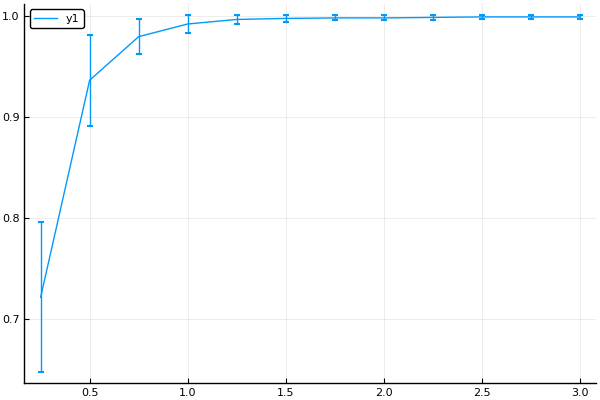

In [31]:
Plots.pyplot() #pyplot backend
Plots.plot(bm_path[:ntop], bm_path[:A_mean], yerr=bm_path[:A_std])

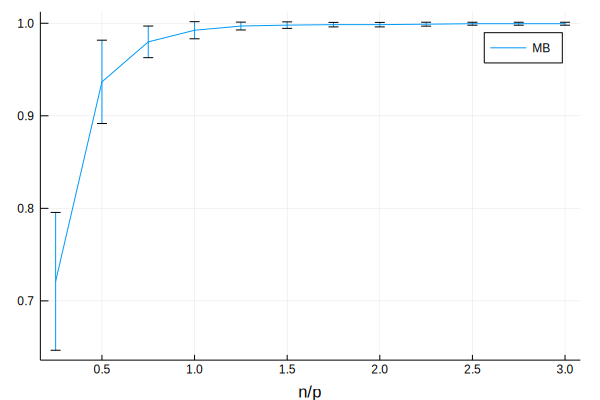

In [32]:
Plots.gr() #GR backend (default)
Plots.plot(bm_path[:ntop], bm_path[:A_mean], yerr=bm_path[:A_std], label="MB", xaxis="n/p")

Use the plot! function to modify the current plot.

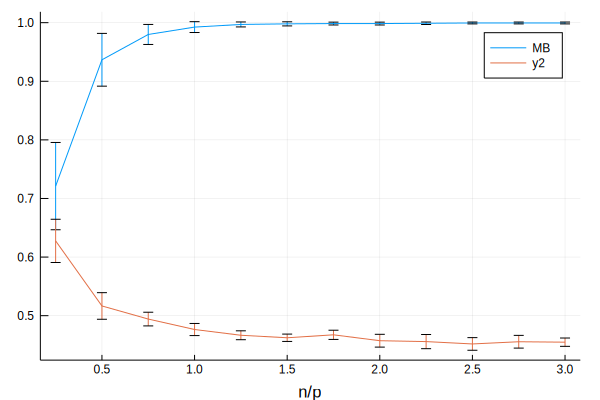

In [33]:
Plots.plot!(bm_path[:ntop], bm_path[:F_mean], yerr=bm_path[:F_std])

>**\[Exercise\]**: Plotting 

> Show on one graph how the accuracy $A$ evolves as $n/p$ increases for all methods

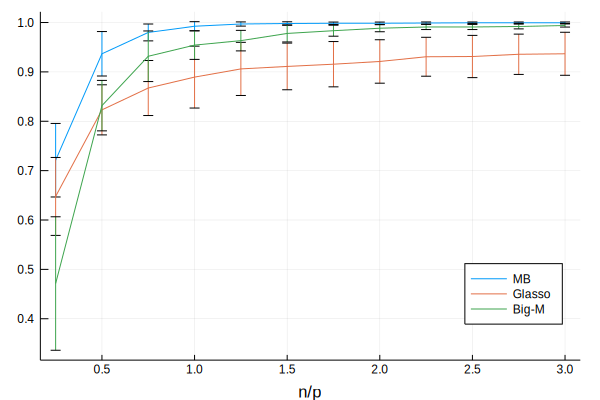

In [34]:
Plots.plot(bm_path[:ntop], bm_path[:A_mean], yerr=bm_path[:A_std], label="MB", xaxis="n/p", legend=:bottomright)
Plots.plot!(glasso_path[:ntop], glasso_path[:A_mean], yerr=glasso_path[:A_std], label="Glasso")
Plots.plot!(bigm_path[:ntop], bigm_path[:A_mean], yerr=bigm_path[:A_std], label="Big-M")

**Bonus: ** 

- Other syntax using the StatPlots package: [**StatPlots.jl**](https://github.com/JuliaPlots/StatPlots.jl) implements some useful recipes in data analysis and statistics
- You can use LaTeX text in your legends using [**LaTeXStrings.jl**](https://github.com/stevengj/LaTeXStrings.jl)

In [35]:
using StatPlots, LaTeXStrings

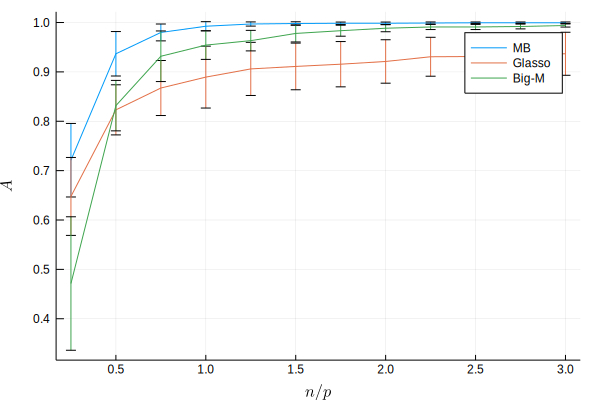

In [36]:
@df bm_path StatPlots.plot(:ntop, :A_mean, yerr=:A_std, label="MB")
@df glasso_path StatPlots.plot!(:ntop, :A_mean, yerr=:A_std, label="Glasso")
@df bigm_path StatPlots.plot!(:ntop, :A_mean, yerr=:A_std, label="Big-M")
xaxis!(L"n/p")
yaxis!(L"A")

It can be tedious to write a line for each method specifically. It would be more efficient to:
- add a column method to each dataframe
- merge the three dataframes into one
- use the method column as a group indicator

In [37]:
bm_path[:method] = "MB"
glasso_path[:method] = "Glasso"
bigm_path[:method] = "Big-M"

"Big-M"

In [38]:
big_df = vcat(bm_path, glasso_path)
big_df = vcat(big_df, bigm_path)

,p,n,ktrue,ntop,A_mean,F_mean,time_mean,A_std,F_std,time_std,method
,Int64⍰,Int64⍰,Int64⍰,Float64,Float64,Float64,Float64,Float64,Float64,Float64,String
1,200,50,199,0.25,0.721106,0.627638,0.785517,0.0744688,0.0368852,0.0882089,MB
2,200,100,199,0.5,0.936683,0.516583,0.883515,0.0450209,0.0226967,0.0817403,MB
3,200,150,199,0.75,0.979899,0.494221,0.931037,0.0170821,0.0116683,0.180514,MB
4,200,200,199,1.0,0.992462,0.476382,0.984862,0.00925072,0.0103392,0.117145,MB
5,200,250,199,1.25,0.996985,0.466583,0.979372,0.00423756,0.0075887,0.156287,MB
6,200,300,199,1.5,0.99799,0.462312,1.02449,0.0035136,0.00626743,0.116822,MB
7,200,350,199,1.75,0.998492,0.467337,0.994539,0.00242737,0.00785664,0.124399,MB
8,200,400,199,2.0,0.998492,0.457286,1.03669,0.00242737,0.0109199,0.201287,MB
9,200,450,199,2.25,0.998995,0.455779,1.06067,0.00211878,0.0120905,0.17787,MB


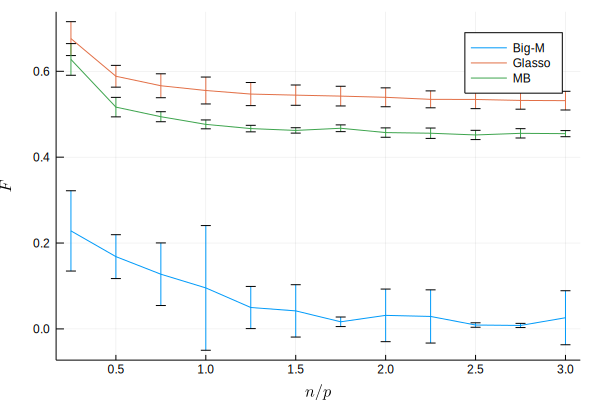

In [39]:
@df big_df StatPlots.plot(:ntop, :F_mean, yerr=:F_std, group=:method, line=1)
xaxis!(L"n/p")
yaxis!(L"F")

## Bonus: Interoperability and RCall

Julia has a growing number of packages implementing basic up to state-of-the-art statistics/ML techniques (e.g. GLM, GLMnet, LibLinear, ...) but is still a young programming language. 

**Good news!** If you ever need to, you can easily interact directly with R or Python

In [40]:
using RCall

You can easily write and compile R code with the Rstring syntaxt

In [41]:
R"1+2"

RObject{RealSxp}
[1] 3


You can use Julia objects in the R code using the "$" prefix

Note: avoid using special characters for variable names

In [42]:
R"$big_df"

RObject{VecSxp}
     p   n ktrue ntop    A_mean      F_mean    time_mean       A_std
1  200  50   199 0.25 0.7211055 0.627638191    0.7855166 0.074468752
2  200 100   199 0.50 0.9366834 0.516582915    0.8835154 0.045020938
3  200 150   199 0.75 0.9798995 0.494221106    0.9310368 0.017082142
4  200 200   199 1.00 0.9924623 0.476381910    0.9848615 0.009250721
5  200 250   199 1.25 0.9969849 0.466582915    0.9793723 0.004237558
6  200 300   199 1.50 0.9979899 0.462311558    1.0244878 0.003513597
7  200 350   199 1.75 0.9984925 0.467336683    0.9945393 0.002427366
8  200 400   199 2.00 0.9984925 0.457286432    1.0366943 0.002427366
9  200 450   199 2.25 0.9989950 0.455778894    1.0606741 0.002118779
10 200 500   199 2.50 0.9994975 0.451758794    1.1340409 0.001589084
11 200 550   199 2.75 0.9994975 0.455527638    1.0972168 0.001589084
12 200 600   199 3.00 0.9994975 0.454773869    1.1032981 0.001589084
13 200  50   199 0.25 0.6477387 0.676130653    1.5010110 0.078938737
14 200 100   199 0

So if you
- do not know how to do something in Julia
- do know how to do it in R 
- are lazy to go from one language into another 

Simply use RCall!

┌ Warning: RCall.jl: 
│ Attaching package: ‘dplyr’
│ 
│ The following objects are masked from ‘package:stats’:
│ 
│     filter, lag
│ 
│ The following objects are masked from ‘package:base’:
│ 
│     intersect, setdiff, setequal, union
│ 
└ @ RCall /Users/jpauph/.julia/packages/RCall/RPlFw/src/io.jl:110


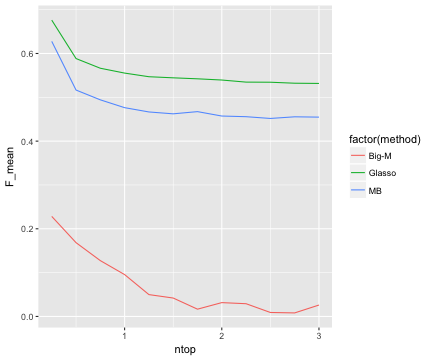

RObject{VecSxp}


In [43]:
R"""
library(dplyr)
library(ggplot2)

$big_df %>% 
    ggplot()+aes(x=ntop, y=F_mean, color=factor(method)) + geom_line()
"""

## Bonus: Saving Julia objects using 

JLD/JLD2 enables to save/load Julia objects very easily (similar to pickle for Python)

In [44]:
using JLD2

In [45]:
@save "test.jld2" big_df

In [47]:
@load "test.jld2" big_df

1-element Array{Symbol,1}:
 :big_df